In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")
import nltk
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
#python -m pip install package_name
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Sajin.LAPTOP-
[nltk_data]     RE0DL8PH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sajin.LAPTOP-
[nltk_data]     RE0DL8PH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sajin.LAPTOP-
[nltk_data]     RE0DL8PH\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

target
0    4342
1    3271
Name: count, dtype: int64


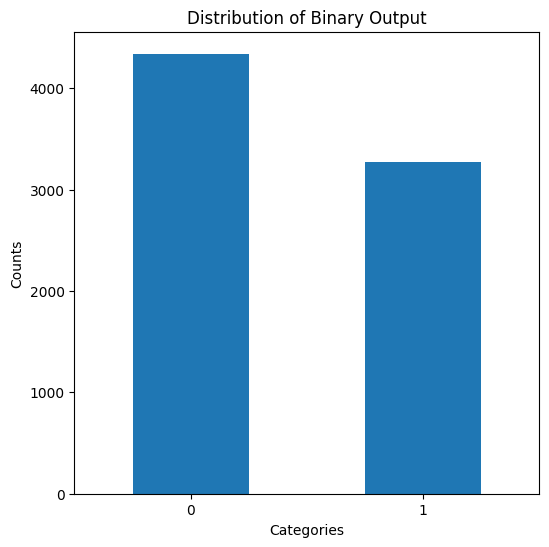

In [3]:
import matplotlib.pyplot as plt

# Calculate counts of each category
counts = train_data['target'].value_counts()
print(counts)

# Plotting
plt.figure(figsize=(6, 6))
counts.plot(kind='bar')
plt.title('Distribution of Binary Output')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Rotate x-labels if needed
plt.show()

In [4]:
from twitter_clean import clean_text,text_mislabels
train_data['clean_text']=train_data['text'].apply(clean_text)
test_data['clean_text']=test_data['text'].apply(clean_text)
train_data.to_csv('train_clean.csv',index=False)
test_data.to_csv('test_clean.csv',index=False)

In [5]:
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
def preprocessing(text):
    tokens=word_tokenize(text.lower().strip())
    filtered_tokens=[token for token in tokens if token not in stop_words]
    lemmatized_spacy = [token.lemma_ for token in nlp(" ".join(filtered_tokens))]
    return " ".join(lemmatized_spacy)#' '.join(tokens)
train_data['preprocessed_text']=train_data['clean_text'].apply(preprocessing)
test_data['preprocessed_text']=test_data['clean_text'].apply(preprocessing)
train_data.to_csv('train_preprocessed.csv',index=False)
test_data.to_csv('test_preprocessed.csv',index=False)

In [6]:
new_train=text_mislabels(train_data,'text','target')
new_train.to_csv('new_train.csv',index=False)

new_target
0.0    4354
1.0    3259
Name: count, dtype: int64


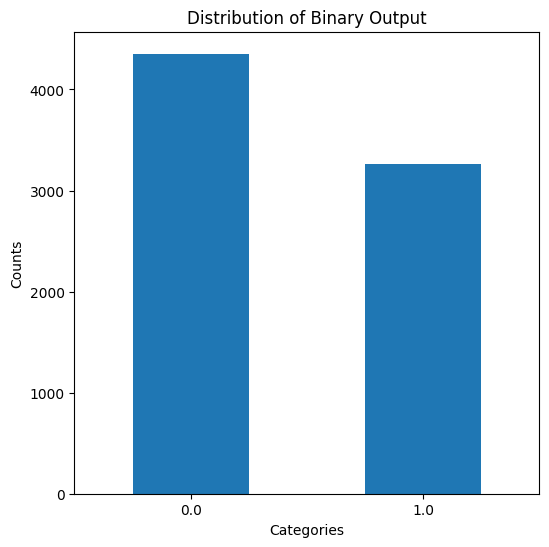

In [7]:
import matplotlib.pyplot as plt

# Calculate counts of each category
counts = new_train['new_target'].value_counts()
print(counts)

# Plotting
plt.figure(figsize=(6, 6))
counts.plot(kind='bar')
plt.title('Distribution of Binary Output')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Rotate x-labels if needed
plt.show()

In [8]:
# Parameters
vocab_size = 10000  # Vocabulary size
max_length = 200    # Maximum length of sequences
padding_type = 'post'
trunc_type = 'post'
oov_token = "<OOV>"

# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(new_train['preprocessed_text'])
train_sequences = tokenizer.texts_to_sequences(new_train['preprocessed_text'])
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
# Model building
embedding_dim = 16

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(24, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
epochs = 10
batch_size = 32

history = model.fit(
    train_padded_sequences,
    new_train['new_target'],
    validation_split=0.2,  # Using a part of the training data for validation
    epochs=epochs,
    batch_size=batch_size
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
__________________________________________________